# Simulation Output Parsing

In [3]:
# import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
import lxml
from lxml import etree
import pysal as ps
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import gzip
# import mplleaflet


## Output File Parsing

The following cells are used to convert the output files into useful data structures (Pandas and numpy) for analysis of simulation results. If you are comparing several simulations or iterations, it may be more practical to use hdf5.

In [4]:
def open_xml(path):
    # Open xml and xml.gz files into ElementTree
    if path.endswith('.gz'):
        return etree.parse(gzip.open(path))
    else:
        return etree.parse(path)

    


In [6]:
%%time
# Parse activities
tree = open_xml("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/sample/15k/population.xml.gz")
root = tree.getroot()
acts = []
for person in root.findall("./person"):
    pid = person.get('id')
    attributes,plan = person.getchildren()
    
    age=int(attributes.findall('./attribute[@name="age"]')[0].text)
    sex = attributes.findall('./attribute[@name="sex"]')[0].text
    activities = plan.getchildren()
    for activity in activities:
        act_type = activity.get('type')
        act_x = activity.get('x')
        act_y = activity.get('y')
        acts.append([pid,age,sex,act_type,act_x,act_y])
        
cols = ['pid','age','sex','type','x','y']
activity_df = pd.DataFrame(acts,columns=cols)
activity_df.set_index('pid',inplace=True)

CPU times: user 844 ms, sys: 103 ms, total: 947 ms
Wall time: 1.96 s


In [4]:
%time
# Parse population attributes and join with activities
tree = open_xml("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/sample/15k/populationAttributes.xml.gz")
root = tree.getroot()
net = []
pop=root.getchildren()
for person in pop: 
    pid = person.get('id')
    attributes = person.findall("./attribute")
    res = {}
    res['pid'] = pid
    for attribute in attributes:
        res[attribute.attrib['name']] = attribute.text
    net.append(res)
pa_df = pd.DataFrame(net)
pa_df.set_index('pid',inplace=True)
pdf=pa_df.join(activity_df)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [7]:
%%time
# Parse households
tree = open_xml("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/sample/15k/households.xml")
root = tree.getroot()
households = []
hh_pid_keys = []
for household in root.findall('./{http://www.matsim.org/files/dtd}household'):
    tmp = []
    hh_pid_key = []
    hid = household.get('id')
    tmp.append(hid)
    members = household.findall('./{http://www.matsim.org/files/dtd}members/')
    vehicles = household.findall('./{http://www.matsim.org/files/dtd}vehicles/')
    income = household.findall('./{http://www.matsim.org/files/dtd}income')[0]
    for member in members:
        hh_pid_key.append([hid,member.get('refId')])
    tmp.append(','.join([member.get('refId') for member in members]))

    tmp.append(','.join([vehicle.get('refId') for vehicle in vehicles]))
       
    tmp.append(float(income.text.strip("\t\n")))
    households.append(tmp)
    hh_pid_keys.extend(hh_pid_key)
cols = ['hid','pids','vids','hh_income']
hdf = pd.DataFrame(households,columns=cols)
hdf.set_index('hid',inplace=True)

cols = ['hid','pid']
hh_p_df = pd.DataFrame(hh_pid_keys,columns=cols)
hh_p_df.set_index('hid',inplace=True)

CPU times: user 267 ms, sys: 34.1 ms, total: 301 ms
Wall time: 327 ms


In [8]:
merged = pd.merge(hdf,hh_p_df,left_index=True,right_index=True)
merged = merged.set_index('pid',append=True).reset_index().set_index('pid')
merged = merged.join(activity_df).drop(['pids','vids'],axis=1)

In [10]:
# Create population point shapefile

from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(pdf.x.astype(float), pdf.y.astype(float))]
pdf = pdf.drop(['x', 'y'], axis=1)
crs = {'init': 'epsg:26914'}
pt_gdf = gpd.GeoDataFrame(pdf, crs=crs, geometry=geometry)


NameError: name 'pdf' is not defined

In [13]:
# Load links gdf
links_gdf=gpd.read_file("/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/shape/links.shp")
links_gdf.set_index('ID',inplace=True)
links_gdf.crs = {'init': 'epsg:26914'}

shp_poly = "/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/shape/sioux_falls_population_counts_by_census_block_dissolved.shp"
sf_gdf = gpd.read_file(shp_poly)
sf_gdf.crs={'init': 'epsg:4326'}
data = ps.pdio.read_files(shp_poly)

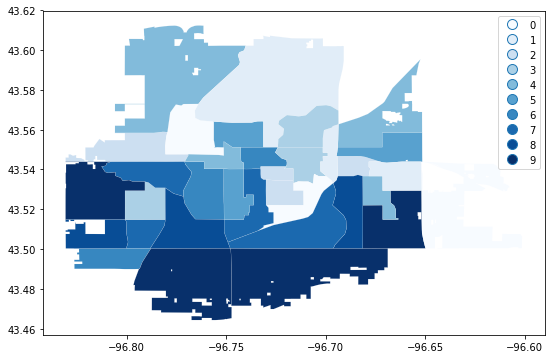

In [14]:
hr10 = ps.Quantiles(data.pop_pct, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
sf_gdf.assign(cl=hr10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='Blues', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)


In [15]:
joined_gdf=gpd.sjoin(sf_gdf.to_crs(epsg=26914),pt_gdf[pt_gdf['type']=='Home'],op='contains')
joined_gdf.income = joined_gdf.income.astype(float)

In [16]:
joined_gdf=gpd.sjoin(sf_gdf.to_crs(epsg=26914),pt_gdf[pt_gdf['type']=='Home'],op='contains')
joined_gdf.income = joined_gdf.income.astype(float)
means = joined_gdf.groupby('tract').mean()
sub_sf_gdf=sf_gdf[sf_gdf.tract.isin(means.index)]

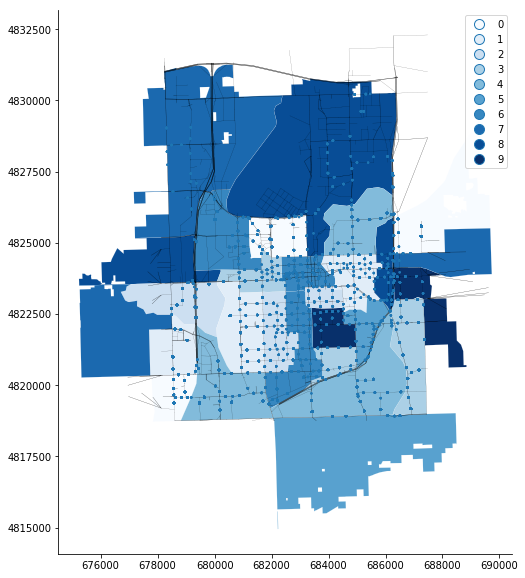

In [17]:
joined_gdf=gpd.sjoin(sf_gdf.to_crs(epsg=26914),pt_gdf[pt_gdf['type']=='Home'],op='contains')
joined_gdf.income = joined_gdf.income.astype(float)
means = joined_gdf.groupby('tract').mean()
sub_sf_gdf=sf_gdf[sf_gdf.tract.isin(means.index)]

hr10 = ps.Quantiles(means.age, k=10)
f, ax = plt.subplots(1, figsize=(10, 10))

sub_sf_gdf.to_crs(epsg=26914).assign(cl=hr10.yb).set_index('tract').join(means,lsuffix='l').plot(column='cl',categorical=True, \
        k=10, cmap='Blues', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax=links_gdf.plot(ax=ax,color='k',linewidth=1)
pt_gdf[pt_gdf['type']=='Home'].plot(column='type',ax=ax,markersize=2.0)
sns.despine()


In [11]:
event_file = "/Users/sfeygi/current_code/scala/projects/beam_competitions/output/sioux_faux/sioux_faux-15k__2019-01-18_18-12-54/outputEvents.xml.gz"

In [12]:
from collections import defaultdict


def parse_events(event_file):
    event_data = {}
    tree = open_xml(event_file)
    root = tree.getroot()
    for event in root.getchildren():
        add_event_data_to_library(event,event_data)
    return convert_to_pandas(event_data)

def add_event_data_to_library(event,event_data):
    attrib = event.attrib
    event_type = attrib['type']
    if event_type not in event_data:
        dd = defaultdict(list)
        event_data[event_type] = dd
    else:
        dd = event_data[event_type]
    for k,v in attrib.items():
        dd[k].append(v)

def convert_to_pandas(event_data):
    dfs = {}
    for k,dataset in event_data.items():
        dfs[k] = pd.DataFrame(dataset)
    return dfs

In [13]:
%%time
dfs=parse_events(event_file)


CPU times: user 8.77 s, sys: 1.31 s, total: 10.1 s
Wall time: 14.2 s


In [21]:
leave_df = dfs['PersonLeavesVehicle']
enter_df = dfs['PersonEntersVehicle']
pt_df=dfs['PathTraversal']

In [23]:
persons = enter_df.person
vehicles = enter_df.vehicle
bus_vehicles = vehicles[vehicles.str.contains('siouxareametro')]
ondemand_ride = vehicles[vehicles.str.contains('rideHailVehicle')]
body_vehicles = vehicles[vehicles.str.contains('body')]
car_vehicles=vehicles[~vehicles.index.isin(list(set(bus_vehicles.index) | set(ondemand_ride.index) | set(body_vehicles.index)))]
vehicle_data={'car':car_vehicles,'body':body_vehicles,'ondemand_ride':ondemand_ride,'bus':bus_vehicles}


In [24]:
pop_vehicle_data = {}
leave_groups = leave_df.groupby('person').groups
for pid,idxs in enter_df.groupby('person').groups.items():
    person_data = {'enters':[],'leaves':[]}
    person_data['enters'] = enter_df.iloc[idxs].drop(['type','person'],axis=1)
    if pid in leave_groups:
        person_data['leaves'] = leave_df.iloc[leave_groups[pid]].drop(['type','person'],axis=1)
    pop_vehicle_data[pid] = person_data

In [130]:
import networkx as nx

netfile = "/Users/sfeygi/current_code/scala/projects/beam_competitions/fixed-data/sioux_faux/r5/physsim-network.xml"
def parse_net(netfile):
    net = open_xml(netfile)
    root = net.getroot()
    nodes=root[1]
    links=root[3]
    G=nx.DiGraph()
    for node in nodes:
        G.add_node(int(node.get('id')), x=float(node.get('x')), y=float(node.get('y')))
    LinkIDMap={}
    LinkIDReverseMap={}
    doubleEdgesNo=0
    for link in links:
        G.add_edge(int(link.get('from')),int(link.get('to')), freespeed=float(link.get('freespeed')),
                    permlanes=float(link.get('permlanes')),capacity=float(link.get('capacity')),
                   length=float(link.get('length')),edgeid=int(link.get('id')))
        LinkIDMap[int(link.get('id'))]= [int(link.get('from')),int(link.get('to'))]
        LinkIDReverseMap[(int(link.get('from')),int(link.get('to')))] = int(link.get('id'))
    return G,LinkIDMap,LinkIDReverseMap

In [26]:
def plot_roads(G):
    # Plots the road network generated by get_roads_from_XML
    
    import networkx as nx
    import matplotlib.pyplot as plt
    nodepos={}
    for nodeix, node in G.node.items():
        nodepos[nodeix]=[node['x'],node['y']]

    nx.draw_networkx_edges(G,nodepos,arrows=False,width=0.5,alpha=0.5)
    fig_size=[12,9]
        #fig_size[0] = 12
        #fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('equal')
    return 0
    

In [27]:
G,LinkIDMap,LinkIDReverseMap=parse_net(netfile)

In [28]:
def get_vehicle_links_db(mode):
    
    veh_df=pt_df[pt_df['mode']==mode]
    vehicle_groups = veh_df.groupby('vehicle').groups

    vehicle_links_db = []
    for vehicle in vehicle_data[mode]:
        a = pt_df.iloc[vehicle_groups[vehicle]]
        tot_pass = a.numPassengers.astype(int)
        trip_links = {}
        hours = (np.floor(a.time.astype(float)/86400.00*24)).astype(int)
        for l,n,h in zip(a.links.values,a.numPassengers.values,hours.values):
            leg_links = [int(i) for i in l.split(',')]
            pass_arr =  [(h,int(n))]*len(leg_links)
            pass_dict = dict(zip(leg_links,pass_arr))
            trip_links.update(pass_dict)
        vehicle_links_db.append(trip_links)
    return vehicle_links_db

In [29]:
def get_link_hrs_db(vehicle_links_db,mode='car'):

    links_db = dict((edgeid,[0]*30) for edgeid in LinkIDMap.keys())
    for vehicle_links in vehicle_links_db:
        for link,(hr,passengers) in vehicle_links.items():
            if mode == 'car' or mode == 'body':
                links_db[link][hr]+=1
            else:
                links_db[link][hr]+=passengers
    return links_db



In [30]:
import warnings
warnings.filterwarnings('ignore')
import imageio


def plot_link_occupancy_gif(mode):
    links_hrs_db = get_link_hrs_db(get_vehicle_links_db(mode),mode)
    nodepos={}
    for nodeix, node in G.node.items():
        nodepos[nodeix]=[node['x'],node['y']]


    fig = plt.figure()
    fig_size=[12,9]

    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('equal')

    filenames = []
    for hr in range(0,30):
        myedgelist = []
        my_pass_num = []
        max_num = 0
        for link,hr_data in links_hrs_db.items():
            if hr_data[hr]==0:
                continue

            myedgelist.append(LinkIDMap[link])

            if mode == 'car':
                max_num = 1.0
                a,b=tuple(LinkIDMap[link])
                occupancy = hr_data[hr]/(G.edge[a][b]['capacity']*0.1)
                my_pass_num.append(occupancy)
                
            else:
                if hr_data[hr]>max_num:
                    max_num = hr_data[hr]
                my_pass_num.append(hr_data[hr])
        plot_roads(G)
        
        im = nx.draw_networkx_edges(G,nodepos,arrows=False,edgelist=myedgelist,edge_cmap=plt.cm.RdYlGn_r,edge_color=my_pass_num,alpha=1.0,width=3.0,vmin=0,vmax=max_num)
        if im is not None:
            im.set_clim(0,max_num)
            plt.colorbar(im)
            plt.title('Sioux Faux: {} link occupancy by hour \n hour:{}'.format(mode,str(hr)))
            filename = 'img/link_occupancy_viz/{}/{}-occupancy-map_hr-{}.png'.format(mode,mode,hr)
            filenames.append(filename)
            plt.savefig(filename)
            plt.show()
        else:
            plt.clf()

    images = []
    for filename in filenames:
            images.append(imageio.imread(filename))
    imageio.mimsave('img/link_occupancy_viz/{}/{}_link-occupancy.gif'.format(mode,mode), images,duration=1)

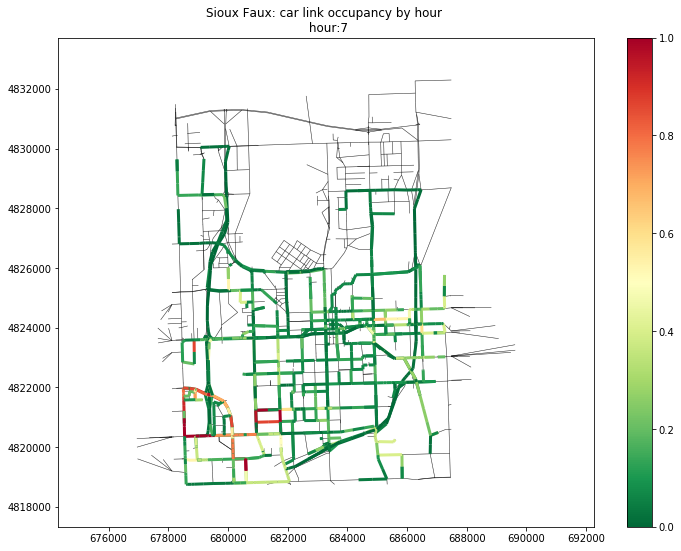

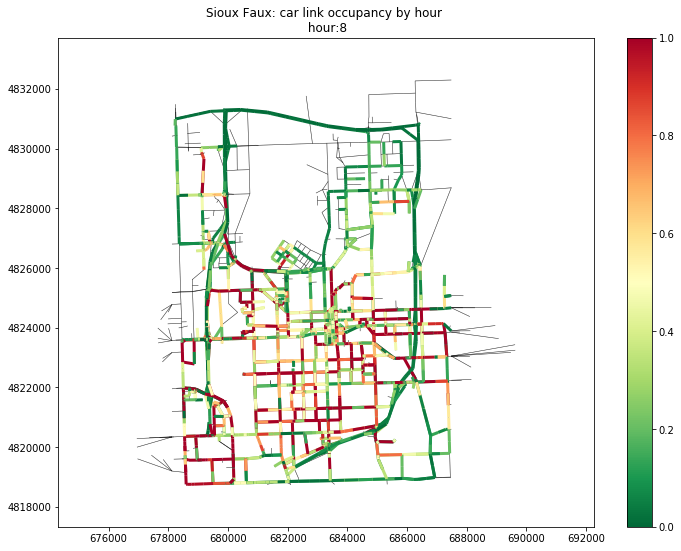

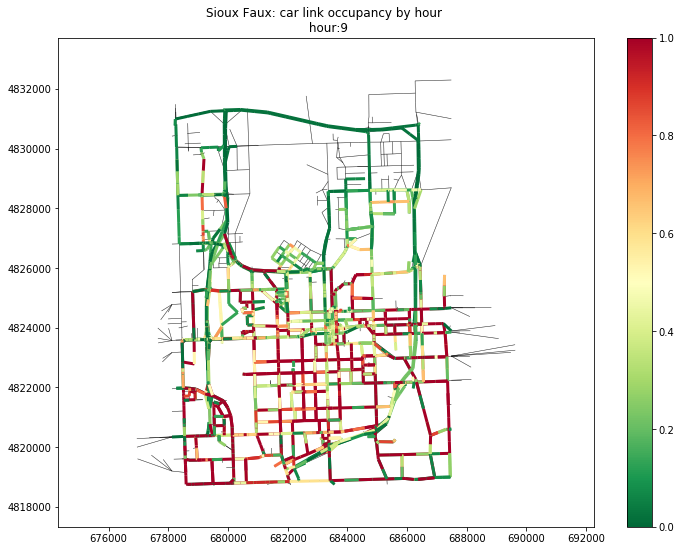

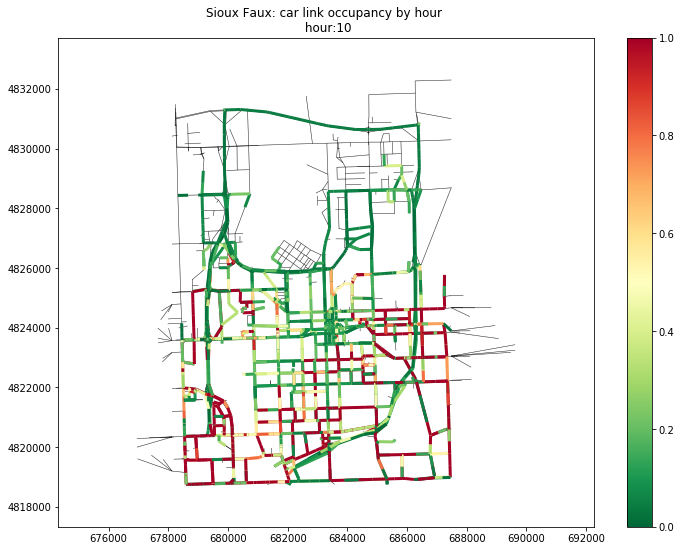

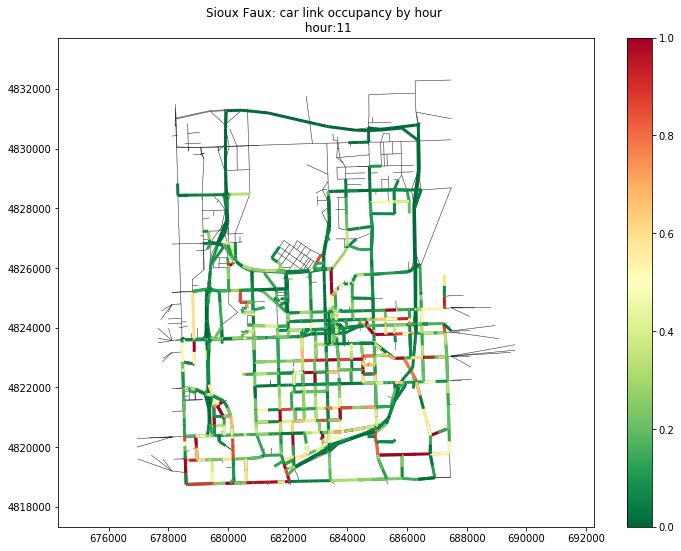

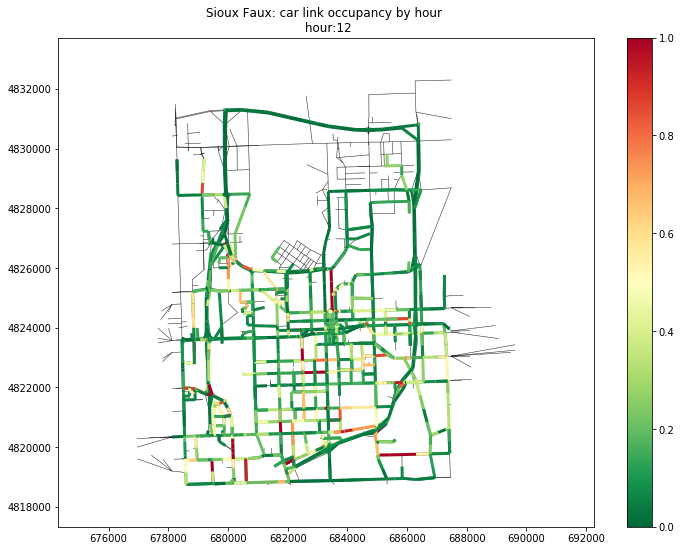

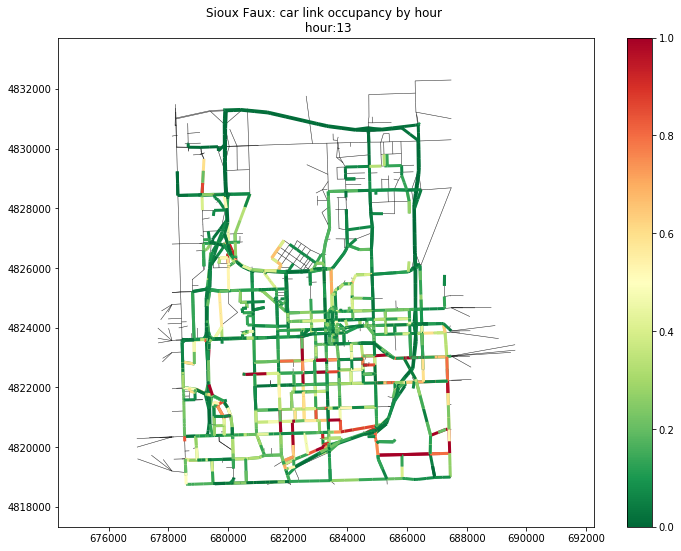

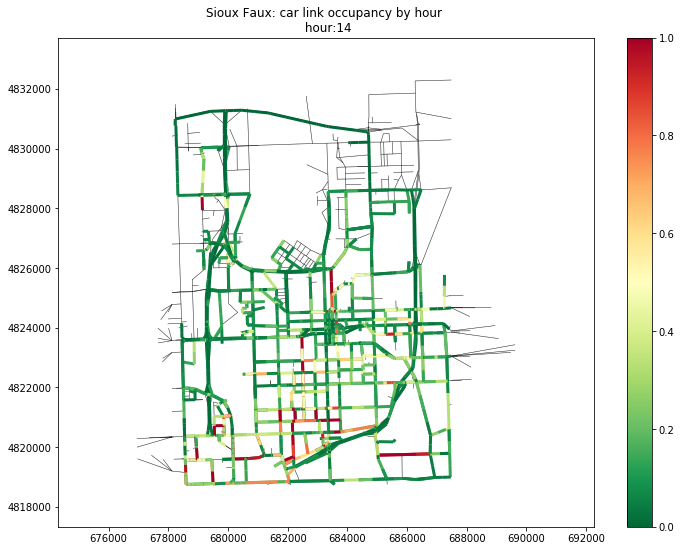

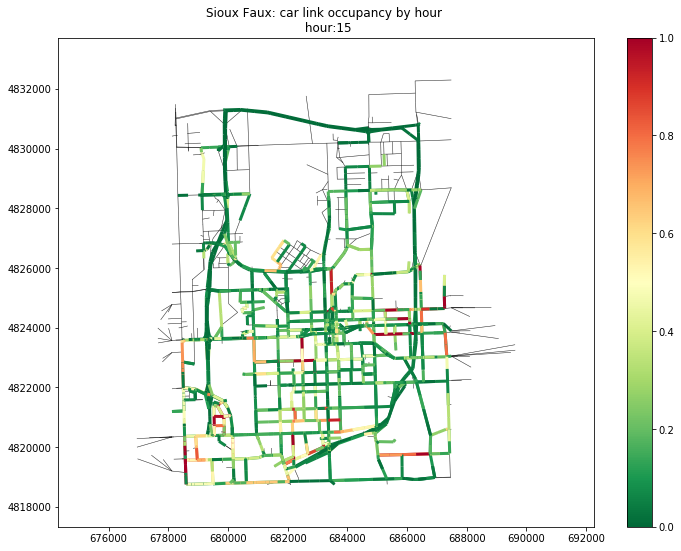

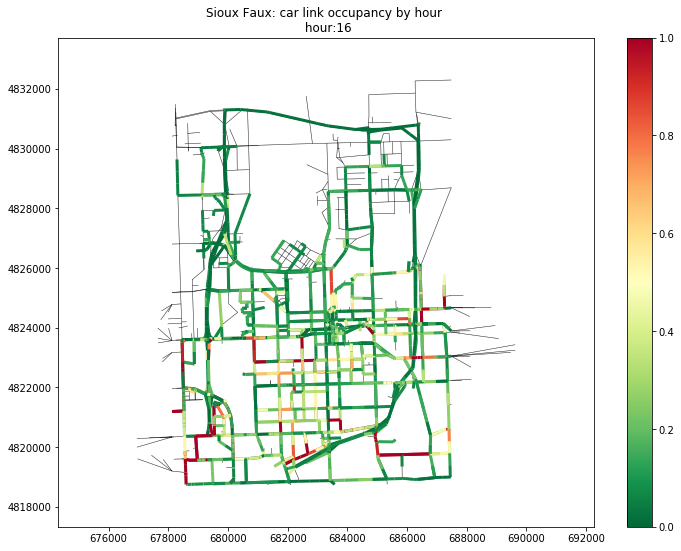

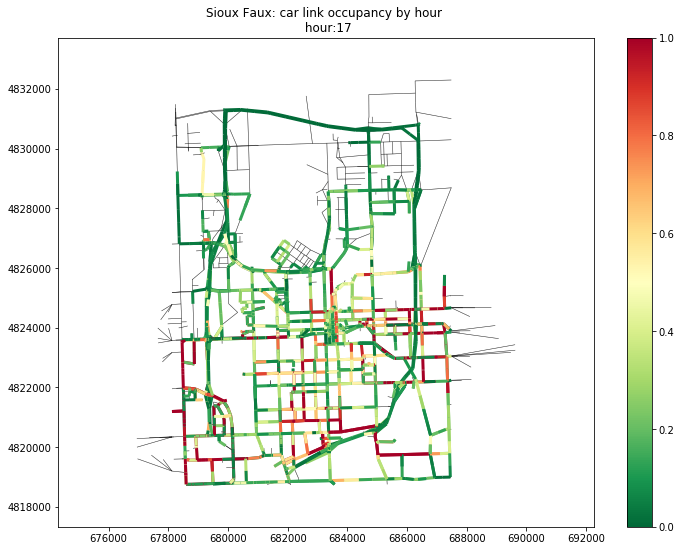

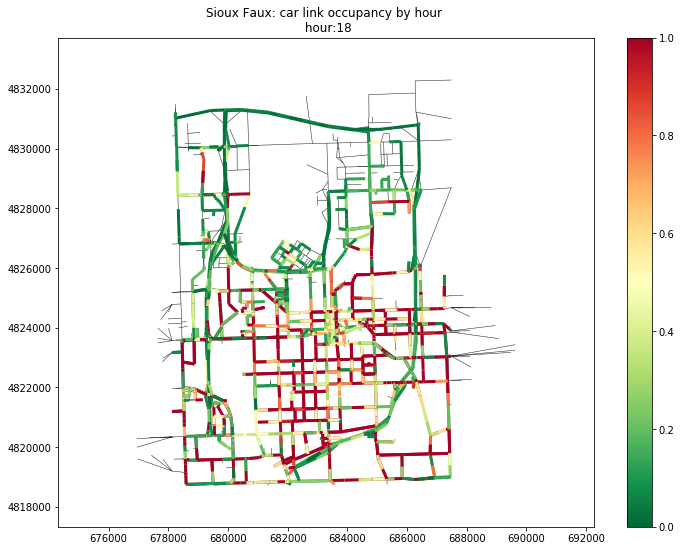

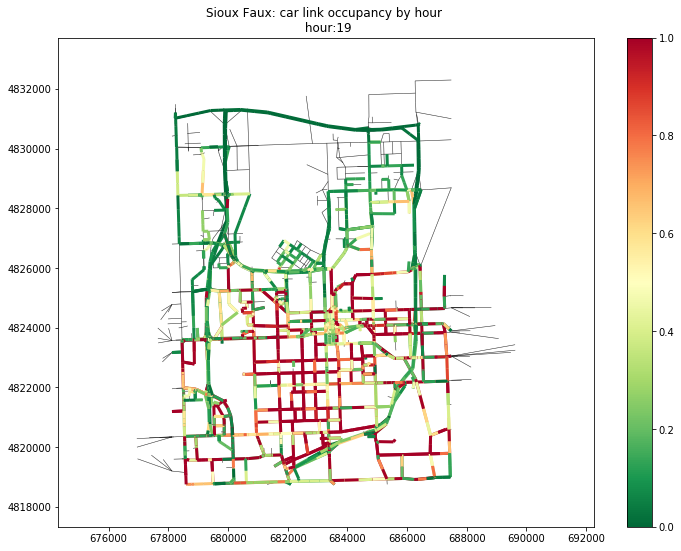

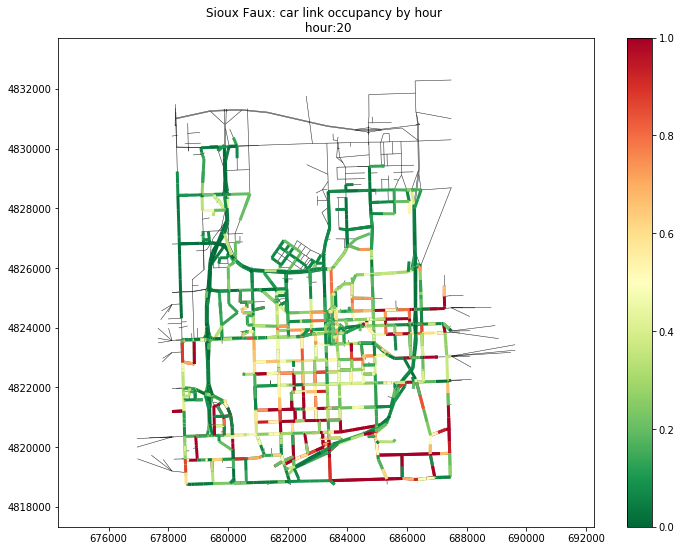

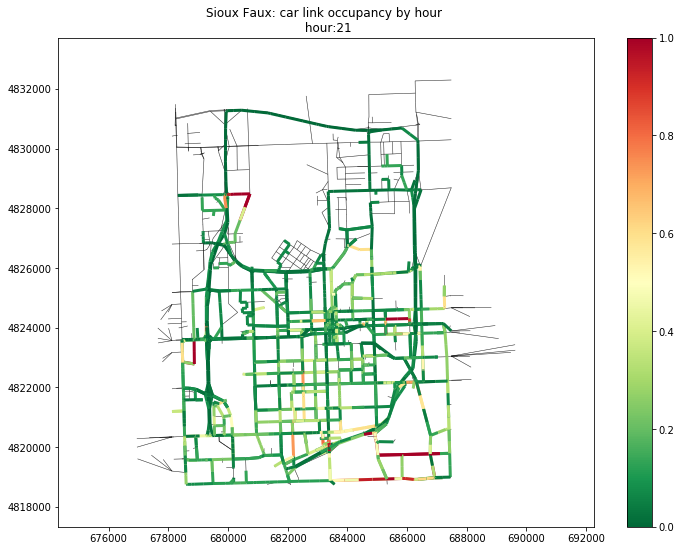

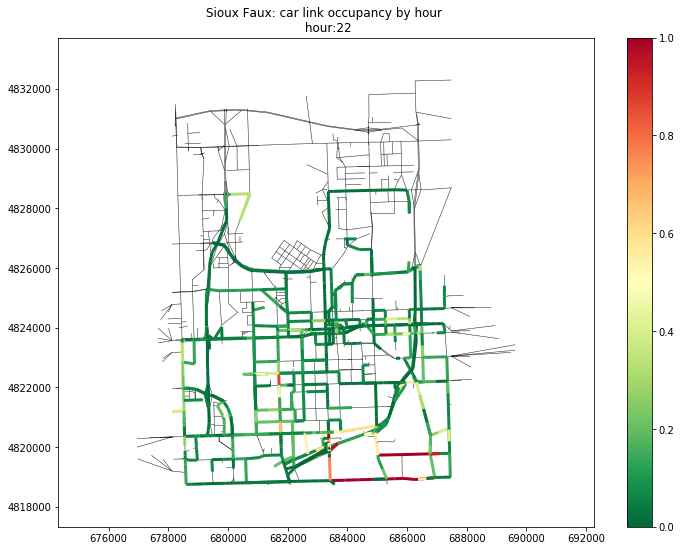

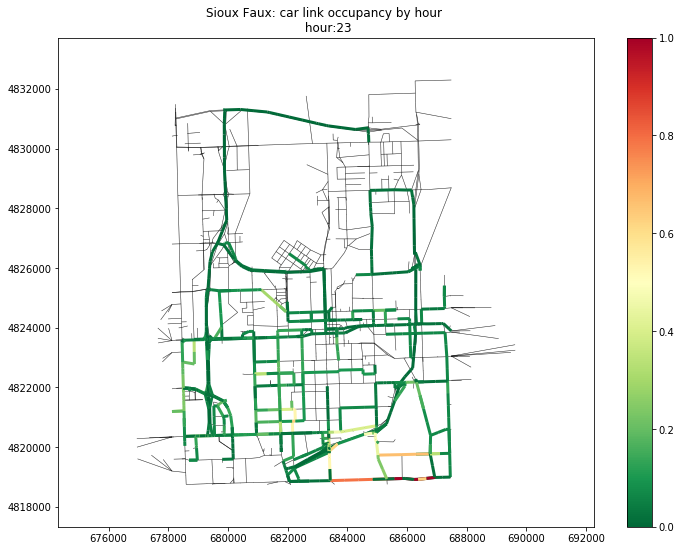

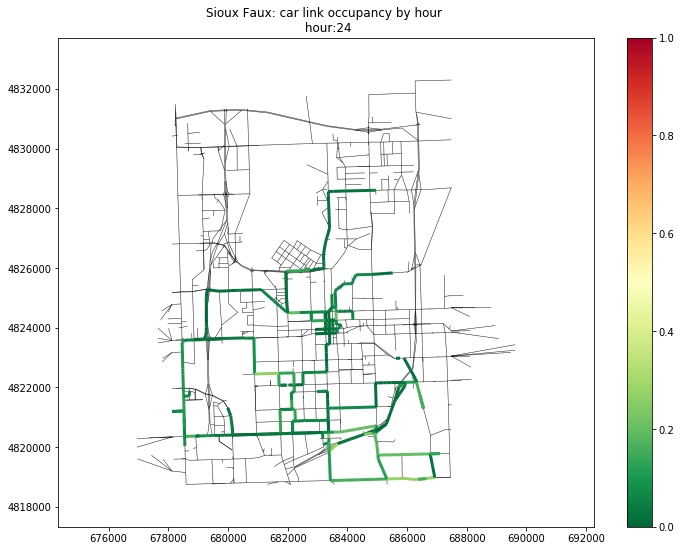

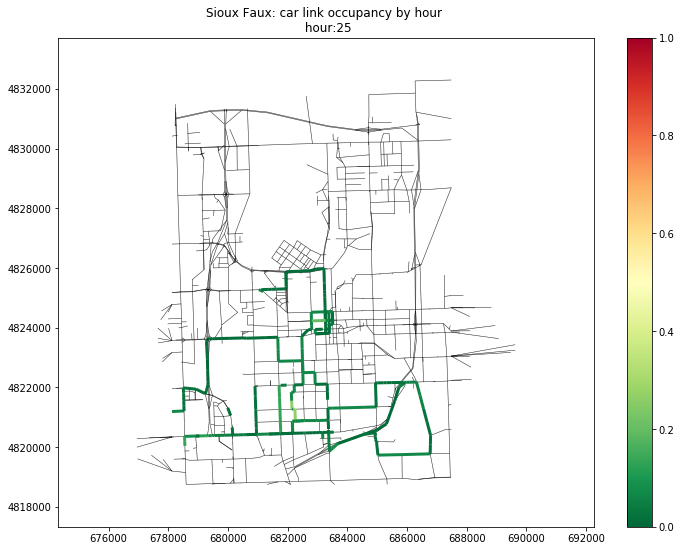

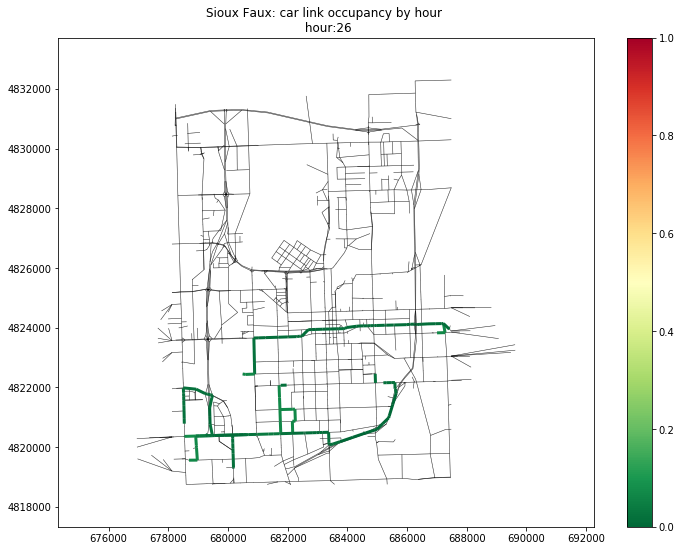

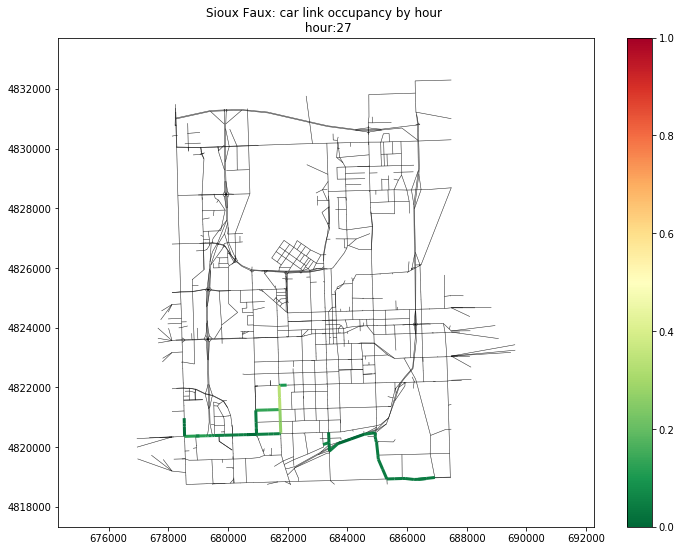

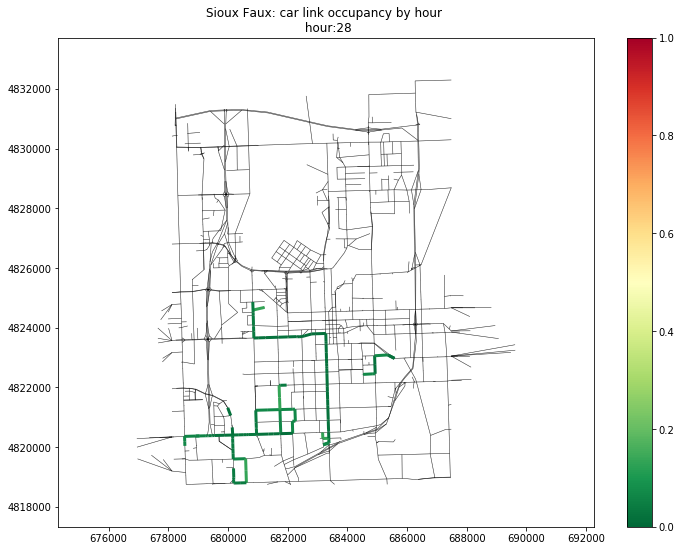

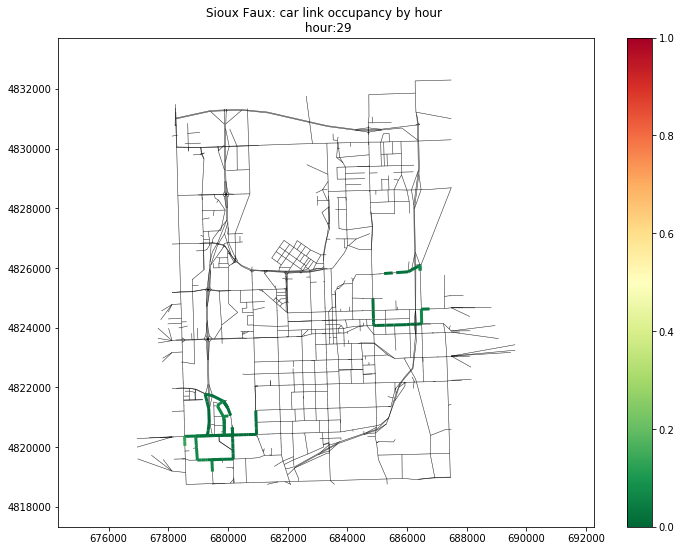

In [179]:
plot_link_occupancy_gif('car')